## Code produit avec l'article: 
https://medium.com/h7w/implementing-a-variational-autoencoder-with-keras-e19d7140ad90

## On entraîne le modèle sur tous les pixels
### Permet de visualiser les dimensions de la carte latente

In [1]:
from keras.layers import Conv1D, Conv2D, Input, Flatten, Dense, MaxPooling1D, MaxPooling2D, BatchNormalization, Concatenate
from keras.optimizers import Adam
from keras import layers
import matplotlib.pyplot as plt
from keras.models import Model
import tensorflow as tf
from PIL import Image
import copy
import numpy as np
import keras
import os
import re



In [2]:
# Fonction pour calculer les coordonées stéréographiques

def stereo(theta, phi):
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    # Projection sur x y
    px = x / (1 + z + 1e-8)
    py = y / (1 + z + 1e-8)
    return px, py

# Importation des images

In [3]:
# Dossier contenant les images
repertoire = "../Bonn_Dataset"
sous_dossiers = ["tv000_pv000"]
img_width, img_height = 50, 50

# Expression pour extraire les infos du nom de fichier
pattern = re.compile(r"(\d+)\s+tl([\d.-]+)\s+pl([\d.-]+)\s+tv([\d.-]+)\s+pv([\d.-]+)\.jpg")

# Stockage des résultats
images_info = []

for dossier in sous_dossiers:
    chemin_dossier = os.path.join(repertoire, dossier)
    print(chemin_dossier)
    for nom_fichier in os.listdir(chemin_dossier):
        print(nom_fichier)
        if nom_fichier.endswith(".jpg"):
            match = pattern.match(nom_fichier)
            if match:
                i, tl, pl, tv, pv = match.groups()
                tl, pl = int(tl), int(pl)
                px, py = stereo(np.radians(tl), np.radians(pl)) # Calcul des coordonnées stéréo
                chemin_image = os.path.join(chemin_dossier, nom_fichier)
                image = Image.open(chemin_image)
                w, h = image.size
                left = (w - img_width) / 2
                top = (h - img_height) / 2
                right = (w + img_width) / 2
                bottom = (h + img_height) / 2
                image = Image.open(chemin_image).crop((left, top, right, bottom))
                pixels = np.array(image, dtype=np.float32) / 255.0

                images_info.append({
                    "tl": tl,
                    "pl": pl,
                    "px": px,
                    "py": py,
                    "image": image,
                    "pixels": pixels,
                })
            else:
                print(f"Nom de fichier ignoré : {nom_fichier}")

# Exemple : affichage d'une info
for info in images_info[:5]:  # juste les 5 premières
    print(f"tl={info['tl']}, pl={info['pl']}, px={info['px']}, py={info['py']}")

../Bonn_Dataset/tv000_pv000
03321 tl060 pl072 tv000 pv000.jpg
05427 tl075 pl150 tv000 pv000.jpg
00243 tl015 pl120 tv000 pv000.jpg
02673 tl045 pl280 tv000 pv000.jpg
03888 tl060 pl198 tv000 pv000.jpg
04374 tl060 pl306 tv000 pv000.jpg
03483 tl060 pl108 tv000 pv000.jpg
03726 tl060 pl162 tv000 pv000.jpg
01701 tl045 pl040 tv000 pv000.jpg
01782 tl045 pl060 tv000 pv000.jpg
03159 tl060 pl036 tv000 pv000.jpg
03564 tl060 pl126 tv000 pv000.jpg
03645 tl060 pl144 tv000 pv000.jpg
04779 tl075 pl030 tv000 pv000.jpg
06075 tl075 pl270 tv000 pv000.jpg
06480 tl075 pl345 tv000 pv000.jpg
01539 tl045 pl000 tv000 pv000.jpg
04860 tl075 pl045 tv000 pv000.jpg
01458 tl030 pl330 tv000 pv000.jpg
02106 tl045 pl140 tv000 pv000.jpg
06399 tl075 pl330 tv000 pv000.jpg
03078 tl060 pl018 tv000 pv000.jpg
03807 tl060 pl180 tv000 pv000.jpg
01377 tl030 pl300 tv000 pv000.jpg
05589 tl075 pl180 tv000 pv000.jpg
02268 tl045 pl180 tv000 pv000.jpg
01863 tl045 pl080 tv000 pv000.jpg
02349 tl045 pl200 tv000 pv000.jpg
00729 tl030 pl060 tv

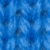

In [4]:
images_info[2]['image']

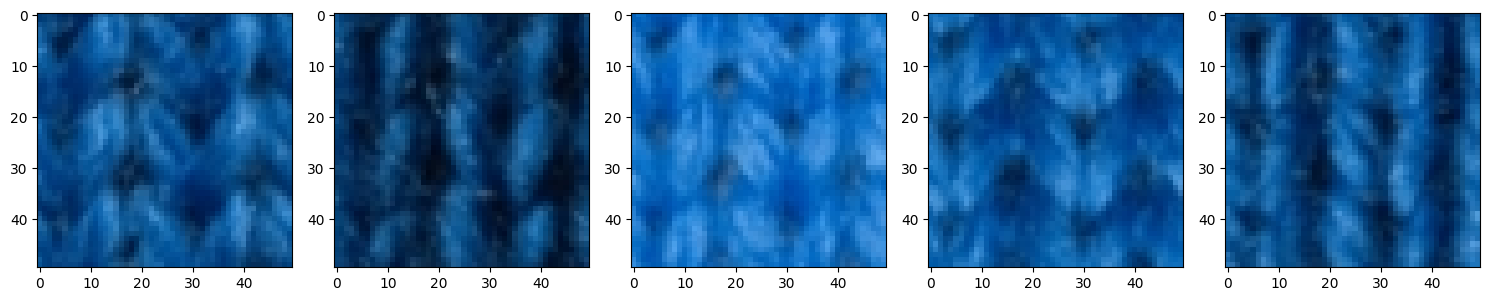

In [5]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5): axes[i].imshow(images_info[i]['pixels'])
plt.tight_layout()
plt.show()

# On trie la liste

In [6]:
sorted = copy.deepcopy(images_info)
sorted.sort(key=lambda d: (d["tl"], d["pl"]))

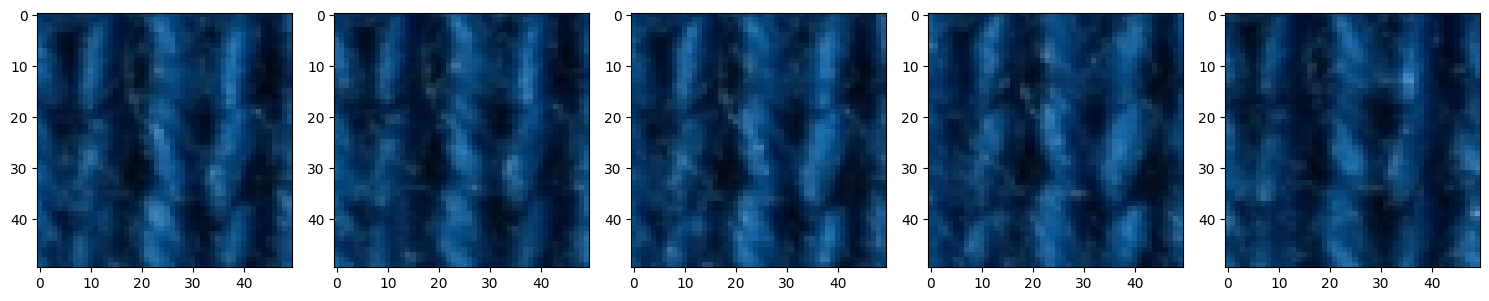

In [10]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5): axes[i].imshow(sorted[i]['pixels'])
plt.tight_layout()
plt.show()

In [11]:
# On trie par position stereo
images_info.sort(key=lambda d: (d["px"], d["py"]))

In [12]:
print("Premier pixel de la troisième image (R,G,B) :", images_info[2]['pixels'][0][0])
print("Nombre d'images importées:", len(images_info))

Premier pixel de la troisième image (R,G,B) : [0.         0.21568628 0.43529412]
Nombre d'images importées: 81


# Création du modèles

In [13]:
latent_dim = 8 # Dimension du bottleneck
num_channels = 3 # RGB
samples = len(images_info) # Nombre de configuration angulaires
matrix_H = 9
matrix_W = 9

input_shape = (samples, num_channels)

# Definition
i = Input(shape=input_shape, name='encoder_input')

# Bloc 1
x = Conv1D(filters = 64, kernel_size=3, padding='same', activation='relu')(i)
x = BatchNormalization()(x) #weight decay
x = MaxPooling1D(pool_size=2)(x)

# Bloc 2
x = Conv1D(filters = 128, kernel_size=3, padding='same', activation='relu')(i)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

# Bloc 3
x = Conv1D(filters = 256, kernel_size=3, padding='same', activation='relu')(i)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

# Bloc 4
x = Conv1D(filters = 512, kernel_size=3, padding='same', activation='relu')(i)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)


# Projection
x = Flatten()(x)
latent_output = Dense(latent_dim, name='latent_output')(x)

# Modèle
encoder = Model(inputs=i, outputs=latent_output, name="Encoder")
encoder.summary()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 81, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 81, 512)        │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 81, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 40, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_output (Dense)           │ (None, 8)              │       163,848 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,016 (668.03 KB)

 Trainable params: 169,992 (664.03 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [14]:
# =================
# Decoder
# =================

# Paramètres
angle_dim = 2  # 2 pour lumière
input_dim = latent_dim + angle_dim  # 8 + 2 = 10

# Entrée
decoder_input = Input(shape=(input_dim,), name='decoder_input')

# 4 couches Fully Connected avec ReLU
x = Dense(106, activation='relu')(decoder_input)

x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)

# Sortie RGB (3 valeurs)
decoder_output = Dense(3, activation='linear', name='rgb_output')(x)

# Modèle
decoder_model = Model(inputs=decoder_input, outputs=decoder_output, name="Decoder")
decoder_model.summary()

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 106)            │         1,166 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rgb_output (Dense)              │ (None, 3)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,513 (138.72 KB)

 Trainable params: 35,513 (138.72 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# =================
# Modele
# =================
view_light_input = Input(shape=(angle_dim,), name='view_light_input')
latent_vector = encoder(i)
decoder_input = Concatenate()([latent_vector, view_light_input])
model_outputs = decoder_model(decoder_input)

model = Model(inputs=[i, view_light_input], outputs=model_outputs, name='Modele')
model.summary()

Model: "Modele"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 81, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder             │ (None, 8)         │    171,016 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ view_light_input    │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10)        │          0 │ Encoder[0][0],    │
│ (Concatenate)       │                   │            │ view_light_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder             │ (None, 3)         │     35,513 │ concatenate[0][0] │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 206,529 (806.75 KB)

 Trainable params: 205,505 (802.75 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [16]:
# --- L2 Loss ---
def custom_reconstruction_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


# Compilation et entraînement
Sur un seul texel pour commencer

In [17]:
# on prend toutes les images
image_stack = np.stack([info["pixels"] for info in images_info], axis=0)
# image_stack.shape = (N_images, height, width, 3)

In [18]:
# on fait de même avec les angles
tl_stack = np.stack([info["tl"] for info in images_info], axis=0)
pl_stack = np.stack([info["pl"] for info in images_info], axis=0)

# et pour les positions stéréo
px_stack = np.stack([info["px"] for info in images_info], axis=0)
py_stack = np.stack([info["py"] for info in images_info], axis=0)

In [19]:
# Préparation des données

# On prend toutes les ABRDF par texel
num_pixels = img_height*img_width
image_stack_flat = image_stack.reshape((samples, num_pixels, num_channels))

texel_observations = np.zeros((num_pixels, samples, num_channels))
texel_observations = np.transpose(image_stack_flat, (1, 0, 2)) # Pour avoir les informations par pixel, on inverse juste les axes
print("Nouvelle forme:", texel_observations.shape)

Nouvelle forme: (2500, 81, 3)


In [20]:
light_dirs = np.stack([px_stack, py_stack], axis=1) # Forme (81, 2)
rep_light_dirs = np.tile(light_dirs, (num_pixels, 1, 1))
target_rgb_train = texel_observations  # (900, 81, 3)

texel_observations.shape, rep_light_dirs.shape, target_rgb_train.shape

((2500, 81, 3), (2500, 81, 2), (2500, 81, 3))

In [21]:
reshaped_input = np.repeat(texel_observations, samples, axis=0)
# Nouvelle forme: (num_pixels * samples, 81, 3)

reshaped_light_dirs = rep_light_dirs.reshape(-1, 2)
# Nouvelle forme: (num_pixels * samples, 2)

reshaped_target_rgb = target_rgb_train.reshape(-1, 3)
# Nouvelle forme: (num_pixels * samples, 3)

reshaped_input.shape, reshaped_light_dirs.shape, reshaped_target_rgb.shape

((202500, 81, 3), (202500, 2), (202500, 3))

# Pre train avant d'utiliser les valeurs de shapley

In [22]:
custom_optimizer = Adam(learning_rate=0.001) # Adam est une version améliorée de la descente de gradient stochastique, par défaut on avait 0.001
model.compile(custom_optimizer, loss=lambda y_true, y_pred: custom_reconstruction_loss(y_true, y_pred))

history = model.fit(
    [reshaped_input, reshaped_light_dirs], # Keras gère le batch_size automatiquement
    reshaped_target_rgb,
    epochs=30,
    batch_size=5, # Keras va prendre 5 pixels à la fois et les passer à l'encodeur/décodeur
    validation_split=0.2
)


Epoch 1/30
32400/32400 ━━━━━━━━━━━━━━━━━━━━ 105s 3ms/step - loss: 0.0047 - val_loss: 0.0019
Epoch 2/30
32400/32400 ━━━━━━━━━━━━━━━━━━━━ 105s 3ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 3/30
32400/32400 ━━━━━━━━━━━━━━━━━━━━ 103s 3ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 4/30
32400/32400 ━━━━━━━━━━━━━━━━━━━━ 108s 3ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 5/30
32400/32400 ━━━━━━━━━━━━━━━━━━━━ 105s 3ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 6/30
32400/32400 ━━━━━━━━━━━━━━━━━━━━ 97s 3ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 7/30
32400/32400 ━━━━━━━━━━━━━━━━━━━━ 99s 3ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 8/30
32400/32400 ━━━━━━━━━━━━━━━━━━━━ 102s 3ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 9/30
32400/32400 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 10/30
32400/32400 ━━━━━━━━━━━━━━━━━━━━ 110s 3ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 11/30
32400/32400 ━━━━━━━━━━━━━━━━━━━━ 110s 3ms/step - loss: 0.0011 - val_lo

dict_keys(['loss', 'val_loss'])


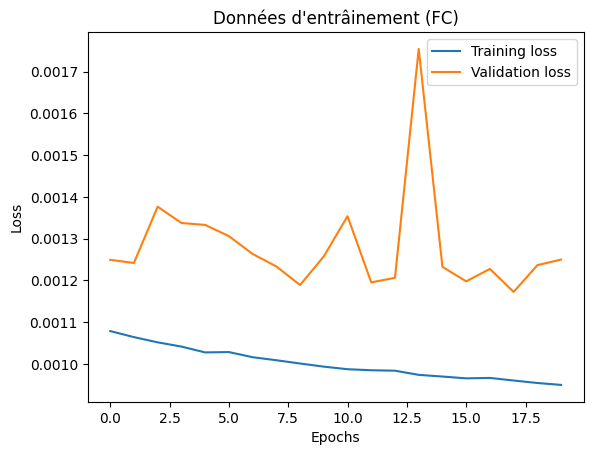

In [24]:
# Evaluer l'apprentissage d'un modèle --Code: Patrick Reuter--
def montrerCourbesApprentissage(history):
    #list all data in history
    print(history.history.keys())

    plt.plot(history.history['loss'][10:], label="Training loss")
    plt.plot(history.history['val_loss'][10:], label="Validation loss")

    plt.title("Données d'entrâinement (FC)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

montrerCourbesApprentissage(history)

# On enregistre le modèle

In [54]:
save_path = os.path.join('modeles/', 'my_model.h5')
model.save(save_path)

enco_save_path = os.path.join('modeles/', 'my_enco_model.h5')
encoder.save(enco_save_path)
decoder_weights_path = os.path.join('modeles/', 'my_decoder.weights.h5')
decoder_model.save_weights(decoder_weights_path)

deco_save_path = os.path.join('modeles/', 'my_deco_model.h5')
decoder_model.save(deco_save_path)
decoder_weights_path = os.path.join('modeles/', 'my_decoder.weights.h5')
decoder_model.save_weights(decoder_weights_path)


# Prédicitions sur un pixel

In [67]:
lum_index = 3
pixel_index = 0
light_direction =light_dirs[lum_index]

latent_vector = encoder.predict(reshaped_input)[pixel_index]  # (8,)

# Prédire pour une direction spécifique (par exemple view_light_train[0])
decoder_input = np.concatenate([latent_vector, light_direction])[np.newaxis, :]
predicted_rgb = decoder_model.predict(decoder_input)  # (1, 3)
print("Predicted RGB:", predicted_rgb, "Original", target_rgb_train[pixel_index, lum_index])

6329/6329 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted RGB: [[0.05282387 0.26701528 0.45431286]] Original [0.0627451  0.32156864 0.54901963]


# Génération de la carte latente

In [79]:
encoder_input_for_all_pixels = texel_observations # Shape: (num_pixels, 81, 3)

# L'encodeur prendra (num_pixels, 81, 3) et produira (num_pixels, latent_dim)
all_latent_vectors = encoder.predict(encoder_input_for_all_pixels, verbose=1)
latent_map = all_latent_vectors.reshape((img_height, img_width, latent_dim))
print(f"Forme de la carte latente: {latent_map.shape}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Forme de la carte latente: (50, 50, 8)


In [80]:
def show_comparaison(latent_map, decoder_model, light_direction_2d, ground_truth_image):
    H, W, latent_dim = latent_map.shape
    num_pixels = H * W

    # Préparer l'entrée du décodeur pour tous les pixels
    latent_flat = latent_map.reshape(-1, latent_dim)  # (H*W, latent_dim)

    # Répéter la direction de lumière pour qu'elle corresponde à chaque pixel
    light_dir_repeated = np.repeat(light_direction_2d[np.newaxis, :], num_pixels, axis=0)

    # Concaténer le vecteur latent de chaque pixel avec la direction de lumière répétée
    decoder_input_combined = np.concatenate([latent_flat, light_dir_repeated], axis=1) # (H*W, latent_dim + angle_dim)


    # Prédiction par le décodeur
    predicted_rgb_flat = decoder_model.predict(decoder_input_combined, verbose=0)  # (H*W, 3)
    predicted_image = predicted_rgb_flat.reshape(H, W, 3) # (H, W, 3)

    # Calcul de la différence absolue
    mse = np.mean(np.square(predicted_image - ground_truth_image))

    
    # Normalisation pour l'affichage et affichage
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    display_predicted = np.clip(predicted_image, 0, 1)
    display_ground_truth = np.clip(ground_truth_image, 0, 1)
    
    # Affichage des images
    axs[0].imshow(display_predicted)
    axs[0].set_title("Image prédite")
    axs[0].axis('off')

    axs[1].imshow(display_ground_truth)
    axs[1].set_title("Image réelle")
    axs[1].axis('off')

    axs[2].axis('off')
    axs[2].text(0.5, 0.5, f"MSE: {mse:.5f}", horizontalalignment='center', verticalalignment='center', fontsize=18, color='black', transform=axs[2].transAxes)
    axs[2].set_title("Erreur de Reconstruction")

    plt.tight_layout()
    plt.show()

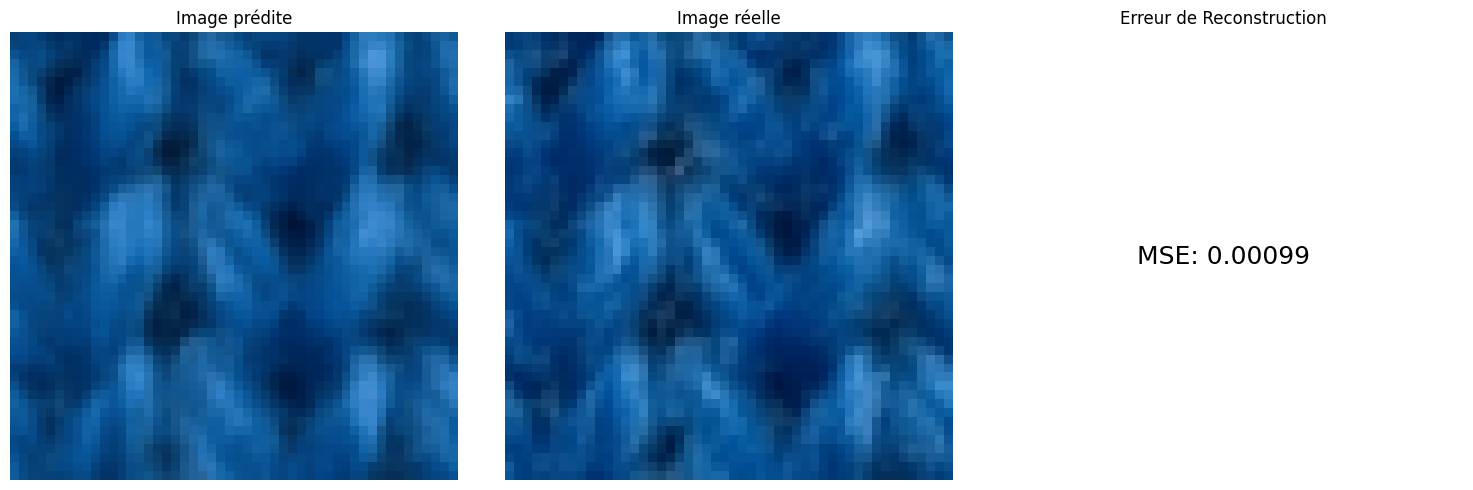

In [82]:
config = 52

angle_to_predict = light_dirs[config]
base_image = image_stack[config]

show_comparaison(latent_map, decoder_model, angle_to_predict, base_image)

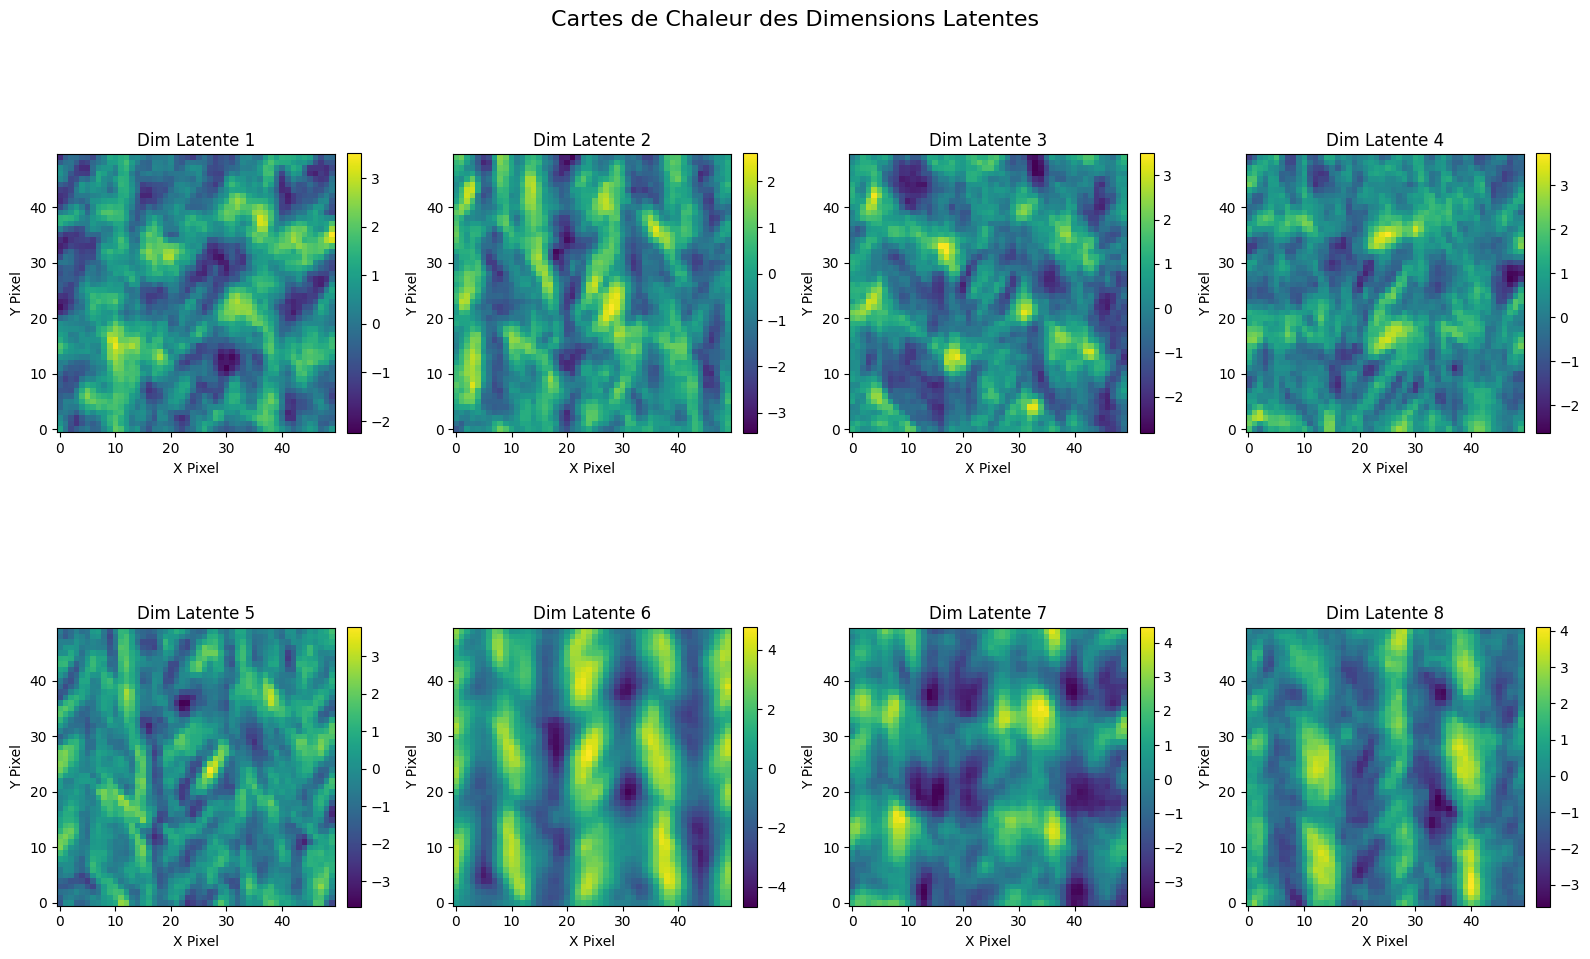

In [35]:
# HEAT MAP

ncols = 4

# Calcule le nombre de lignes nécessaires
nrows = (latent_dim + ncols - 1) // ncols # Division entière avec plafond

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 5 * nrows))

# Aplatir le tableau d'axes pour itérer facilement, quelle que soit la forme (1D ou 2D)
axes = axes.flatten()

for i in range(latent_dim):
    ax = axes[i]
    # Afficher la i-ème dimension latente comme une image 2D
    im = ax.imshow(latent_map[:, :, i], cmap='viridis', origin='lower')
    ax.set_title(f'Dim Latente {i+1}')
    ax.set_xlabel('X Pixel')
    ax.set_ylabel('Y Pixel')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04) # Ajuster la barre de couleur

# Masquer les subplots vides si latent_dim n'est pas un multiple de ncols
for j in range(latent_dim, len(axes)):
    fig.delaxes(axes[j]) # Supprime les axes vides

plt.tight_layout()
plt.suptitle('Cartes de Chaleur des Dimensions Latentes', y=1.02, fontsize=16) # y=1.02 pour laisser de la place au titre principal
plt.show()

## On peut essayer le TSNE

Forme des données pour t-SNE: (2500, 8)
Calcul de t-SNE...


/Users/sebych/miniforge3/envs/MLStuff/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE calculé en 6.57 secondes.
Forme des données après t-SNE: (2500, 2)


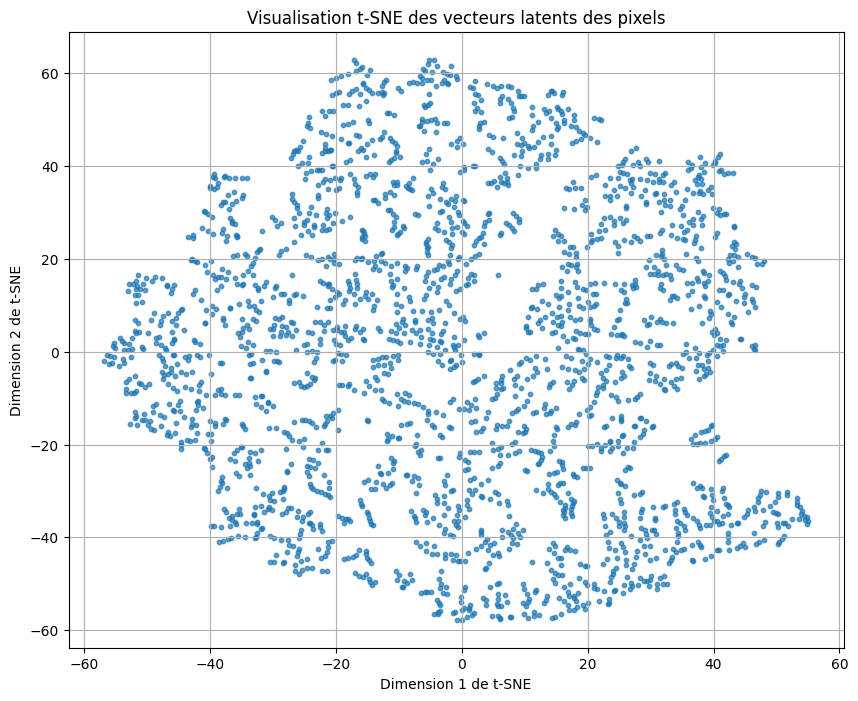

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time # Pour mesurer le temps d'exécution de t-SNE

# Préparation des données pour t-SNE

# Votre latent_map a la forme (img_height, img_width, latent_dim)
# t-SNE s'attend à un tableau 2D de forme (n_samples, n_features)
# Ici, chaque "sample" est un vecteur latent de pixel, et les "features" sont les dimensions latentes.

H, W, latent_dim = latent_map.shape
num_pixels = H * W

# Aplatir la carte latente pour obtenir tous les vecteurs latents de pixels
latent_map.reshape(-1, latent_dim) #va transformer (H, W, latent_dim) en (H*W, latent_dim)
latent_vectors_flat = latent_map.reshape(num_pixels, latent_dim)

print(f"Forme des données pour t-SNE: {latent_vectors_flat.shape}")

# - n_components: la dimension de l'espace de sortie (généralement 2 pour la visualisation 2D)
# - perplexity: mesure l'équilibre entre l'attention portée aux voisins locaux et globaux (valeur typique entre 5 et 50)
# - n_iter: nombre maximum d'itérations
# - learning_rate: taux d'apprentissage de l'optimisation
# - random_state: pour la reproductibilité des résultats

print("Calcul de t-SNE...")
start_time = time.time()

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, learning_rate=200, random_state=42)
# Vous pouvez ajuster perplexity, n_iter et learning_rate en fonction de vos données et de la qualité de la visualisation.
# Pour des datasets plus petits, une perplexité plus faible peut être nécessaire.

# Effectuer la réduction de dimensionnalité
# Le résultat 'latent_2d' aura la forme (num_pixels, 2)
latent_2d = tsne.fit_transform(latent_vectors_flat)

end_time = time.time()
print(f"t-SNE calculé en {end_time - start_time:.2f} secondes.")
print(f"Forme des données après t-SNE: {latent_2d.shape}")

# --- 3. Visualisation des résultats t-SNE ---

plt.figure(figsize=(10, 8))

# Chaque point dans 'latent_2d' représente un pixel.
# Nous pouvons colorer ces points par leur position X ou Y dans l'image originale
# ou même par une dimension latente spécifique pour voir les corrélations.

# Option 1: Colorer les points par leur position en X ou Y dans l'image originale
# Utile pour voir si t-SNE préserve la structure spatiale.
# x_coords_original = np.tile(np.arange(W), H) # Coordonnées X de l'image originale
# y_coords_original = np.repeat(np.arange(H), W) # Coordonnées Y de l'image originale

# plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=x_coords_original, cmap='viridis', s=10, alpha=0.7)
# plt.colorbar(label="Position X originale du pixel")
# plt.title("t-SNE des vecteurs latents (couleur par coordonnée X)")

# Option 2: Colorer les points par la couleur RGB moyenne du pixel original (ou une dimension latente spécifique)
# C'est souvent plus intéressant pour voir les regroupements de matériaux.
# Pour cette option, vous auriez besoin des couleurs RGB moyennes des pixels avant l'encodage.
# Sinon, on peut simplement utiliser un colormap par défaut ou regarder la densité des points.

# Option 3: Afficher simplement les points sans couleur spécifique si vous n'avez pas de labels
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=10, alpha=0.7) # 's' est la taille des points, 'alpha' est la transparence

plt.title("Visualisation t-SNE des vecteurs latents des pixels")
plt.xlabel("Dimension 1 de t-SNE")
plt.ylabel("Dimension 2 de t-SNE")
plt.grid(True)
plt.show()

# --- Interprétation ---
# Les amas de points dans le graphique t-SNE suggèrent que les pixels correspondants
# ont des vecteurs latents similaires. Cela signifie que le modèle les perçoit
# comme ayant des propriétés ABRDF (matériau) similaires.
# Si vous aviez des "labels" de matériaux pour chaque pixel, vous pourriez colorer les points
# en fonction de ces labels pour voir si t-SNE regroupe bien les mêmes matériaux.
# Pour l'ABRDF, cela peut être par exemple des regroupements de pixels de la même texture,
# du même type de brillance, etc.

Forme des données pour t-SNE: (2500, 8)
Calcul de t-SNE... Cela peut prendre un certain temps pour de grandes quantités de données.


/Users/sebych/miniforge3/envs/MLStuff/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE calculé en 6.49 secondes.
Forme des données après t-SNE: (2500, 2)


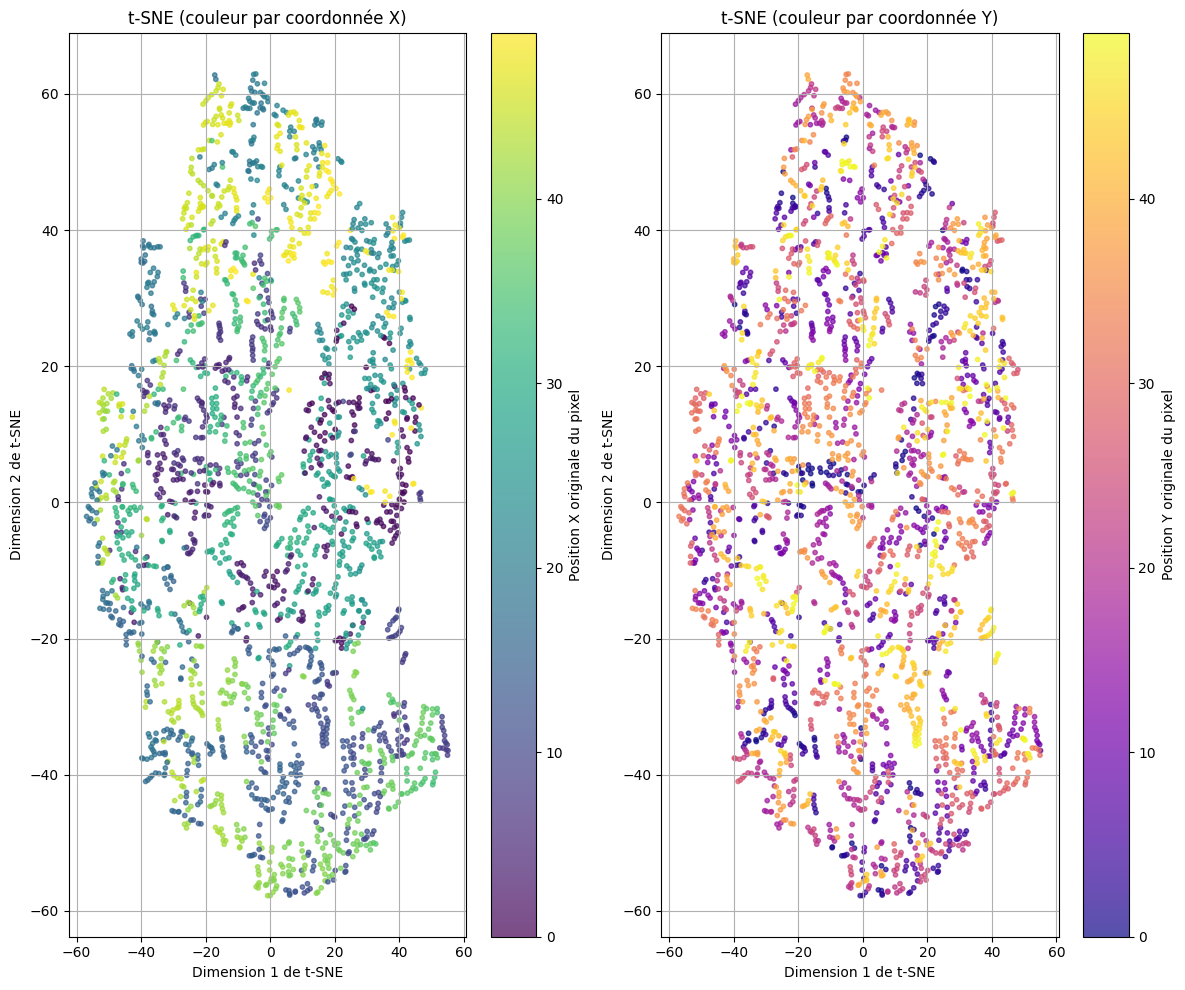

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time # Pour mesurer le temps d'exécution de t-SNE

# --- Données d'exemple (remplacez par votre 'latent_map') ---
# Supposons que latent_map est déjà défini, par exemple:
# latent_map = np.random.rand(100, 100, 32) # Exemple: image 100x100, 32 dimensions latentes
# Si vous n'avez pas encore latent_map, décommentez la ligne ci-dessus pour un test.

# --- Fin des données d'exemple ---


# --- 1. Préparation des données pour t-SNE ---
# Votre latent_map a la forme (img_height, img_width, latent_dim)
# t-SNE s'attend à un tableau 2D de forme (n_samples, n_features)
# Ici, chaque "sample" est un vecteur latent de pixel, et les "features" sont les dimensions latentes.

H, W, latent_dim = latent_map.shape
num_pixels = H * W

# Aplatir la carte latente pour obtenir tous les vecteurs latents de pixels
# latent_map.reshape(-1, latent_dim) va transformer (H, W, latent_dim) en (H*W, latent_dim)
latent_vectors_flat = latent_map.reshape(num_pixels, latent_dim)

print(f"Forme des données pour t-SNE: {latent_vectors_flat.shape}")

# --- 2. Application de t-SNE ---
# Les paramètres de t-SNE sont importants.
# - n_components: la dimension de l'espace de sortie (généralement 2 pour la visualisation 2D)
# - perplexity: mesure l'équilibre entre l'attention portée aux voisins locaux et globaux (valeur typique entre 5 et 50)
# - n_iter: nombre maximum d'itérations
# - learning_rate: taux d'apprentissage de l'optimisation
# - random_state: pour la reproductibilité des résultats

print("Calcul de t-SNE... Cela peut prendre un certain temps pour de grandes quantités de données.")
start_time = time.time()

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, learning_rate=200, random_state=42)
# Vous pouvez ajuster perplexity, n_iter et learning_rate en fonction de vos données et de la qualité de la visualisation.
# Pour des datasets plus petits, une perplexité plus faible peut être nécessaire.

# Effectuer la réduction de dimensionnalité
# Le résultat 'latent_2d' aura la forme (num_pixels, 2)
latent_2d = tsne.fit_transform(latent_vectors_flat)

end_time = time.time()
print(f"t-SNE calculé en {end_time - start_time:.2f} secondes.")
print(f"Forme des données après t-SNE: {latent_2d.shape}")

# --- 3. Visualisation des résultats t-SNE avec coloration par position du pixel ---

plt.figure(figsize=(12, 10))

# Générer les coordonnées X et Y pour chaque pixel de l'image originale
# Ces tableaux seront de la même longueur que latent_2d (num_pixels)
x_coords_original = np.tile(np.arange(W), H) # Répète 0, 1, ..., W-1 H fois
y_coords_original = np.repeat(np.arange(H), W) # Répète chaque ligne (0, ..., H-1) W fois

# --- Choisissez votre option de coloration ---

# Option 1: Colorer les points par leur position X dans l'image originale
plt.subplot(1, 2, 1) # Créer une sous-figure pour cette option
scatter1 = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=x_coords_original, cmap='viridis', s=10, alpha=0.7)
plt.colorbar(scatter1, label="Position X originale du pixel")
plt.title("t-SNE (couleur par coordonnée X)")
plt.xlabel("Dimension 1 de t-SNE")
plt.ylabel("Dimension 2 de t-SNE")
plt.grid(True)

# Option 2: Colorer les points par leur position Y dans l'image originale
plt.subplot(1, 2, 2) # Créer une autre sous-figure
scatter2 = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=y_coords_original, cmap='plasma', s=10, alpha=0.7)
plt.colorbar(scatter2, label="Position Y originale du pixel")
plt.title("t-SNE (couleur par coordonnée Y)")
plt.xlabel("Dimension 1 de t-SNE")
plt.ylabel("Dimension 2 de t-SNE")
plt.grid(True)

plt.tight_layout() # Ajuster les sous-figures pour éviter les chevauchements
plt.show()

# Option supplémentaire: Colorer par une combinaison de X et Y (par exemple, distance au centre, ou simplement une valeur unique)
# Ceci peut être utile si vous voulez visualiser la structure spatiale globale.
# Par exemple, une distance euclidienne par rapport au coin supérieur gauche ou une valeur linéaire
# combined_coords = x_coords_original + y_coords_original * W # Ou toute autre combinaison
# plt.figure(figsize=(10, 8))
# scatter3 = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=combined_coords, cmap='magma', s=10, alpha=0.7)
# plt.colorbar(scatter3, label="Combinaison (X + Y*W) de la position originale")
# plt.title("t-SNE (couleur par combinaison des coordonnées X et Y)")
# plt.xlabel("Dimension 1 de t-SNE")
# plt.ylabel("Dimension 2 de t-SNE")
# plt.grid(True)
# plt.show()

# TSNE version avec les pixels labelisés
#### On peut faire un image ou on a du bois, du métal, de la céramique, et voir si notre réseau à réussi à capter ces structures

In [ ]:
# Exemple de création d'une carte de labels (REMPLACEZ CELA PAR VOS VRAIS LABELS !)
# Pour la démonstration, je vais créer une carte simple avec 3 catégories
# Supposons img_height = 50, img_width = 50
img_height, img_width = 50, 50 # Assurez-vous que ces valeurs correspondent à celles de votre latent_map

material_labels_map = np.zeros((img_height, img_width), dtype=int)
# Exemple:
material_labels_map[0:25, :] = 0 # Zone supérieure: Mat (Label 0)
material_labels_map[25:50, 0:25] = 1 # Zone inférieure gauche: Bois (Label 1)
material_labels_map[25:50, 25:50] = 2 # Zone inférieure droite: Métal (Label 2)

# Si vos labels sont des noms, vous devrez les mapper à des entiers:
# material_names = ["mat", "bois", "métal"]
# label_to_int = {name: i for i, name in enumerate(material_names)}
# material_labels_map = ... (remplir avec les entiers correspondants)

In [ ]:
# Aplatir les labels des matériaux
material_labels_flat = material_labels_map.flatten() # Forme (H*W,)
print(f"Forme des labels aplatis: {material_labels_flat.shape}")

In [23]:
# Code adapté pour la coloration:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time

# --- Code de préparation des données et t-SNE (repris de la réponse précédente) ---
# Assurez-vous que latent_map est déjà défini et a la forme (img_height, img_width, latent_dim)
H, W, latent_dim = latent_map.shape
num_pixels = H * W
latent_vectors_flat = latent_map.reshape(num_pixels, latent_dim)

print(f"Forme des données pour t-SNE: {latent_vectors_flat.shape}")

print("Calcul de t-SNE... Cela peut prendre un certain temps pour de grandes quantités de données.")
start_time = time.time()

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, learning_rate=200, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors_flat)

end_time = time.time()
print(f"t-SNE calculé en {end_time - start_time:.2f} secondes.")
print(f"Forme des données après t-SNE: {latent_2d.shape}")

# --- NOUVEAU: Préparation des labels de couleur pour t-SNE ---
# Remplacer cette section par votre propre logique pour obtenir les labels de matériau par pixel.
# EXEMPLE DE LABELS (À REMPLACER !)
material_labels_map = np.zeros((H, W), dtype=int)
material_labels_map[0:H//2, :] = 0 # Par exemple, la moitié supérieure est "Mat"
material_labels_map[H//2:H, 0:W//2] = 1 # Moitié inférieure gauche est "Bois"
material_labels_map[H//2:H, W//2:W] = 2 # Moitié inférieure droite est "Métal"

# Définir un mappage des labels numériques aux noms (optionnel mais utile pour la légende)
label_names = {
    0: "Mat (Label 0)",
    1: "Bois (Label 1)",
    2: "Métal (Label 2)"
}
# Vous pouvez aussi définir une palette de couleurs si vous voulez des couleurs spécifiques
# import matplotlib.colors as mcolors
# colors = ['red', 'green', 'blue'] # Exemples
# cmap = mcolors.ListedColormap(colors)

# Aplatir les labels pour qu'ils correspondent à chaque point de t-SNE
material_labels_flat = material_labels_map.flatten()

# --- Visualisation des résultats t-SNE avec coloration par label ---

plt.figure(figsize=(12, 10))

# Utilisez 'c' pour spécifier les couleurs et 'cmap' pour la palette de couleurs
# 's' pour la taille des points, 'alpha' pour la transparence
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1],
                      c=material_labels_flat,
                      cmap='viridis', # Ou 'tab10' si vous avez beaucoup de catégories distinctes
                      s=10,
                      alpha=0.7)

plt.title("Visualisation t-SNE des vecteurs latents des pixels (couleur par type de matériau)")
plt.xlabel("Dimension 1 de t-SNE")
plt.ylabel("Dimension 2 de t-SNE")
plt.grid(True)

# Ajouter une légende pour les couleurs (très important ici)
# Si vous avez un nombre défini de labels, vous pouvez créer une légende personnalisée
handles = []
labels = []
unique_labels = np.unique(material_labels_flat)
for label_val in unique_labels:
    # Trouver l'indice d'un point avec cette valeur de label
    idx = np.where(material_labels_flat == label_val)[0][0]
    # Créer un point de scatter avec la couleur correspondante pour la légende
    handles.append(plt.Line2D([0], [0], marker='o', color=scatter.cmap(scatter.norm(label_val)),
                              linestyle='', markersize=10))
    labels.append(label_names.get(label_val, f"Label {label_val}")) # Utilise le nom si dispo, sinon le numéro

plt.legend(handles=handles, labels=labels, title="Type de Matériau", bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajuster la mise en page pour laisser de la place à la légende
plt.show()

NameError: name 'latent_map' is not defined